In [1]:
import sys
import numpy as np
import math
sys.path.append("../build/python")  # set to correct path for module
import varttpy

In [2]:
## IRLM model
L=100
t=1
V=0.15
U=-0.5

## Kinetic energy TB Hamiltonian
K=np.zeros((L,L))
for i in range(1,L-1):
    K[i,i+1]=K[i+1,i]=t

K[0,1]=K[1,0]=V

## U ni nj
Umat=np.zeros((L,L))
Umat[0,1]=U
K[0,0]=K[1,1]=-U/2

## Diagonalize the bath
ek,R = np.linalg.eigh(K[2:,2:])
Rfull=np.identity(L)
Rfull[2:,2:]=R
Krot = np.transpose(Rfull) @ K @ Rfull

Vijkl={}
model = varttpy.Fermionic(Krot,Umat,Vijkl)
H=model.Ham()
print("H: ",[M.shape[-1] for M in H.cores])

H:  [4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1]


In [3]:
sol=varttpy.DMRG(H)
sol.bond_dim=128
sol.nIter_diag=32
Npart=model.NParticle();
print("sweep energy Npart")
eners=[]
for i in range(6):
    sol.iterate()
    print(i+1, sol.energy, sol.Expectation(Npart))
    eners += [sol.energy]

variance_rel=sol.H2(4*sol.bond_dim)/sol.energy**2-1
print("H^2/E^2-1=", variance_rel)

sweep energy Npart
1 -62.55315719042535 49.844138806789516


IOStream.flush timed out


2 -62.56854886589406 49.99989742083989
3 -62.568556671313665 49.99999999866098
4 -62.56855667158036 49.99999999994896
5 -62.56855667158089 49.99999999994854
6 -62.56855667158051 49.99999999994844
H^2/E^2-1= -1.48991929904696e-13


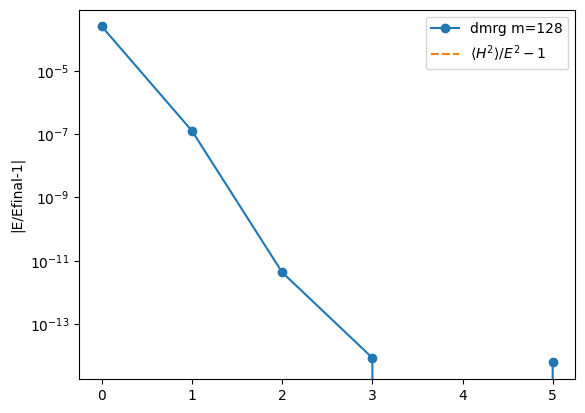

In [4]:
import matplotlib.pyplot as plt
plt.yscale('log')
eRef=np.min(eners)
plt.ylabel("|E/Efinal-1|")
plt.plot([abs(x/eRef-1) for x in eners], '-o', label=f'dmrg m={sol.bond_dim}')
plt.plot([variance_rel for x in eners], '--', label="$\\langle H^2 \\rangle /E^2-1$")
plt.legend()

In [5]:
from multiprocessing import Pool
ij_l=[]
for i in range(L):
    for j in range(i,L):
        ij_l += [[i,j]]

def f(ij):
    return sol.Expectation(model.CidCj(ij[0], ij[1]))

with Pool() as p:
    cc=(p.map(f, ij_l))

cmat=np.zeros((L,L))
c=0
for i in range(L):
    for j in range(i,L):
        cmat[i,j]=cmat[j,i]=cc[c]
        c=c+1
eval=np.sort( np.linalg.eigvals(cmat) )

/home/yurielnf/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


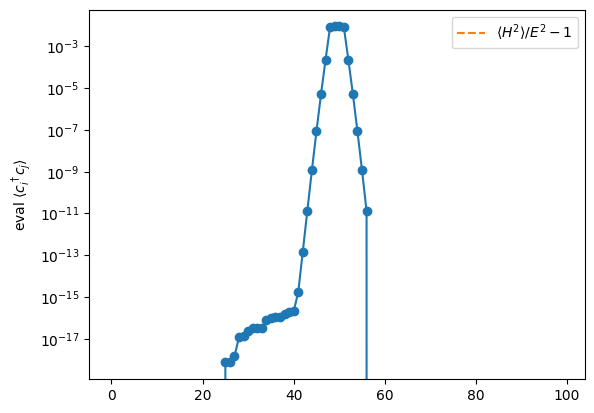

In [6]:
import matplotlib.pyplot as plt
plt.ylabel('eval $ \\langle c_i^\dagger c_j \\rangle$')
plt.yscale('log')
plt.plot([min(x,1-x) for x in eval], '-o')
plt.plot([variance_rel for x in eval], '--', label="$\\langle H^2 \\rangle /E^2-1$")
plt.legend()

In [7]:
print("Npart=",sol.Expectation(Npart))
print("H2-E^2 sigma/E")
ener=sol.Expectation(model.Ham())
m=sol.bond_dim
for mi in [m//2, m, 2*m, 3*m, 4*m]:
    print(sol.H2(mi)/ener**2-1, sol.sigma(mi)/sol.energy  )

Npart= 49.99999999994844
H2-E^2 sigma/E
4.261035968511351e-13 -5.996177177462838e-10
4.218847493575595e-14 -1.7568310135600253e-09
-8.537615059367454e-14 -2.7321707732000177e-09
-8.559819519859957e-14 -2.744729611482024e-09
-8.559819519859957e-14 -2.744744814923394e-09
